This notebook defines and instantiates a U-Net architecture for image segmentation, which is then trained on the [Oxford pet database](https://www.robots.ox.ac.uk/~vgg/data/pets/).

Code is taken from [here](https://blog.paperspace.com/unet-architecture-image-segmentation/), [here](https://blog.paperspace.com/understanding-canet-architecture/), [here](https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96) and [here](https://keras.io/examples/vision/oxford_pets_image_segmentation/) and tweaked for better explanation.

# U-Net architecture

## Imports

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

## Convolution block

In [2]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

## Downsampling block

In [3]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

## Upsampling block

In [4]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

## Whole architecture

In [5]:
def U_Net(Image_Size, num_classes):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

## Taking a look at the architecture

In [6]:
input_shape = (160, 160, 3)
model = U_Net(input_shape, num_classes = 20)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 160, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 160, 160, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

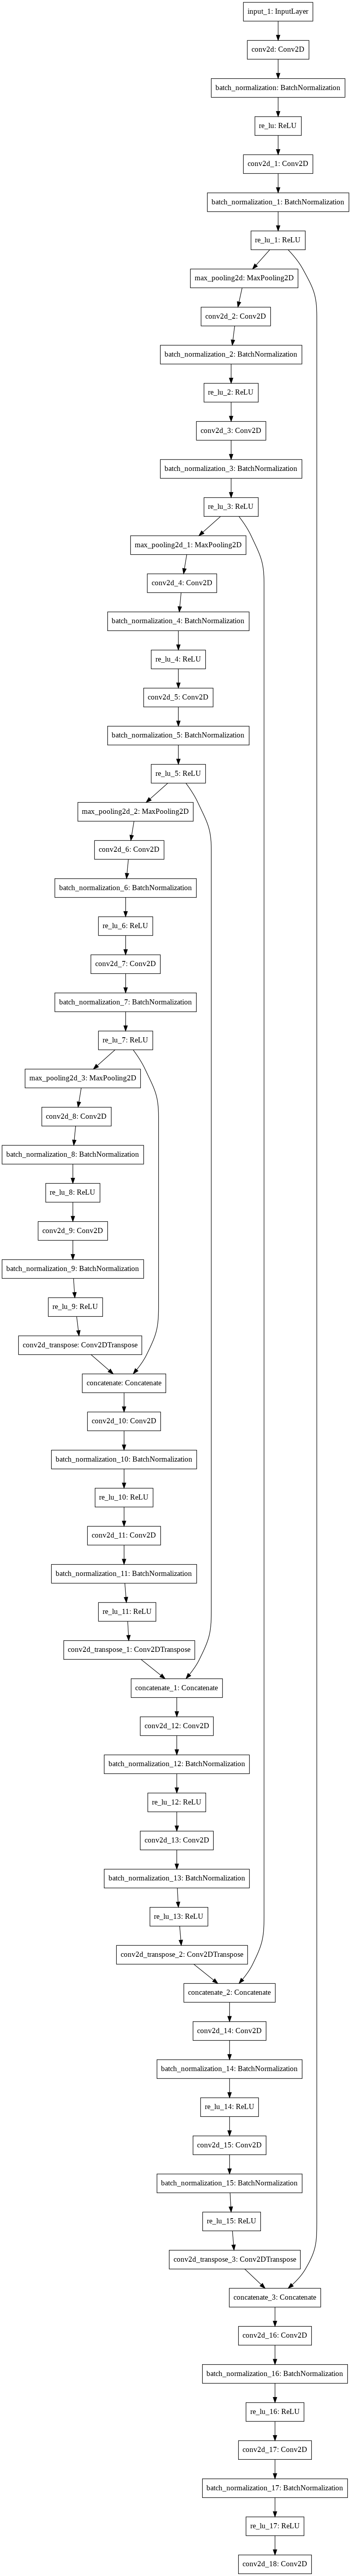

In [7]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

# Pet dataset

## Download


In [8]:
import os

#if one of the file is there we assume everything was already downloaded
if not os.path.isfile('annotations/README'):
  #downloading the archives
  !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
  !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
  #unpacking
  !tar -xf images.tar.gz
  !tar -xf annotations.tar.gz
  #deleting the archives
  !rm images.tar.gz
  !rm annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  28.0M      0  0:00:26  0:00:26 --:--:-- 29.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  10.4M      0  0:00:01  0:00:01 --:--:-- 10.4M


## Data description

In [9]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_pet_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

#A bit of interface: printing number of images and the first 10 file names
print("Number of samples:", len(input_img_paths))
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## Taking a look at one of the images

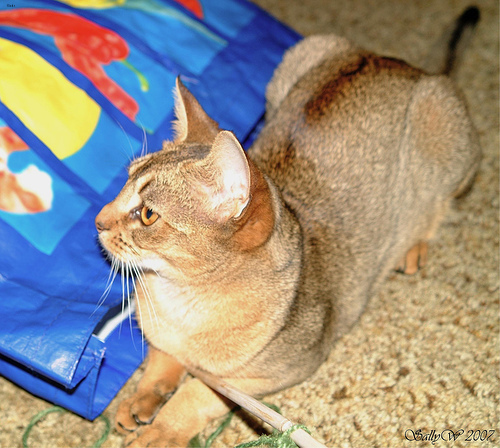

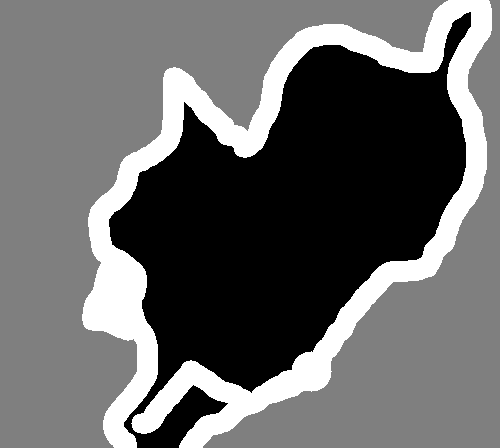

In [10]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)


## Sequence helper

In [11]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


# Training

## Train/validatin split

In [12]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)


## Installing segmentation_models module (via pip)

In [13]:
#This module is required for IoU and Dice scores
!pip install segmentation_models

     |████████████████████████████████| 50 kB 4.5 MB/s 


## Defining the Dice Loss (Jaccard index)

In [14]:
from keras import backend as K

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    #added these two casts to force same type
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    #this below is wassname's original code
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    
    return (1 - jac) * smooth

## Model instantiation

In [15]:
num_pet_classes = 3
input_shape = (160, 160, 3)
model = U_Net(input_shape, num_classes = num_pet_classes)

import segmentation_models as sm
from segmentation_models.metrics import iou_score

model.compile(optimizer="rmsprop", loss=jaccard_distance_loss, metrics=[iou_score])

Segmentation Models: using `keras` framework.


## Model training

In [16]:
# Train the model, doing validation at the end of each epoch.
epochs = 15

history = model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
199/199 [==============================] - 326s 1s/step - loss: 0.4941 - iou_score: 0.8095 - val_loss: 1.2062 - val_iou_score: 0.4909
Epoch 2/15
199/199 [==============================] - 276s 1s/step - loss: 0.1799 - iou_score: 0.9254 - val_loss: 1.0720 - val_iou_score: 0.5343
Epoch 3/15
199/199 [==============================] - 276s 1s/step - loss: 0.0942 - iou_score: 0.9594 - val_loss: 0.3276 - val_iou_score: 0.8568
Epoch 4/15
199/199 [==============================] - 276s 1s/step - loss: 0.0496 - iou_score: 0.9779 - val_loss: 0.0833 - val_iou_score: 0.9652
Epoch 5/15
199/199 [==============================] - 275s 1s/step - loss: 0.0204 - iou_score: 0.9904 - val_loss: 0.1858 - val_iou_score: 0.9268
Epoch 6/15
199/199 [==============================] - 277s 1s/step - loss: -0.0044 - iou_score: 1.0012 - val_loss: 0.0104 - val_iou_score: 0.9947
Epoch 7/15
199/199 [==============================] - 276s 1s/step - loss: -0.0208 - iou_score: 1.0084 - val_loss: 0.1132 - val_i

## Plot loss and metrics

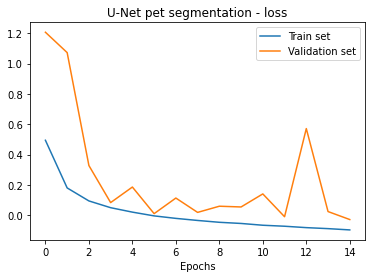

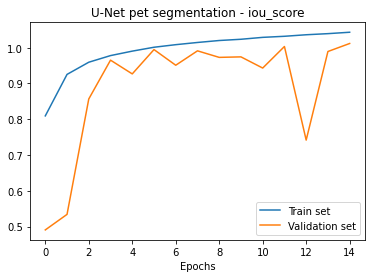

In [17]:
import matplotlib.pyplot as plt

#a handy function to plot loss and metrics
def plot_loss_history(h, title):
  for metric in h.history.keys():
    #ignoring metrics on validation set, which are implied when
    #plotting on training set
    if metric.startswith('val_'):
      continue
    
    #if we get here we found a metric on the training set,
    #let's plot it
    plt.plot(h.history[metric], label = "Train set")
    plt.plot(h.history["val_" + metric], label = "Validation set")
    plt.xlabel('Epochs')
    plt.title(title + ' - ' + metric)
    plt.legend()
    plt.show()

#let's use the function we just defined
plot_loss_history(history, title = 'U-Net pet segmentation')

## Predict the validation set

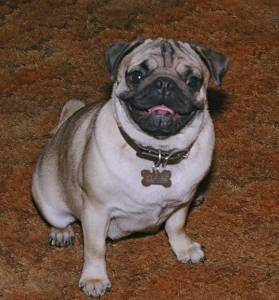

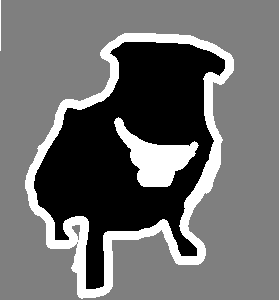

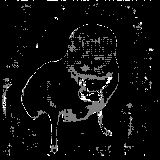

In [18]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

# Alternative loss function

Keras offers a different loss function which could be used for segmentation: [sparse_categorical_crossentropy()](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) 

It's:

* categorical: that's expected, since segmentation is intrinsically a categorical problem
* crossentropy: we already met this
* sparse: useful for very unbalanced classes

In [ ]:
model2 = U_Net(input_shape, num_classes = num_pet_classes)
model2.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=[iou_score])
history2 = model2.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
199/199 [==============================] - 280s 1s/step - loss: 0.6894 - iou_score: 0.4566 - val_loss: 4.3608 - val_iou_score: 0.4059
Epoch 2/15
199/199 [==============================] - 275s 1s/step - loss: 0.5190 - iou_score: 0.4573 - val_loss: 0.9953 - val_iou_score: 0.4856
Epoch 3/15
199/199 [==============================] - 273s 1s/step - loss: 0.4277 - iou_score: 0.4530 - val_loss: 0.5978 - val_iou_score: 0.4726
Epoch 4/15
199/199 [==============================] - 273s 1s/step - loss: 0.3771 - iou_score: 0.4488 - val_loss: 0.6509 - val_iou_score: 0.4542
Epoch 5/15
199/199 [==============================] - 274s 1s/step - loss: 0.3417 - iou_score: 0.4465 - val_loss: 0.5333 - val_iou_score: 0.4521
Epoch 6/15
199/199 [==============================] - 274s 1s/step - loss: 0.3184 - iou_score: 0.4427 - val_loss: 0.3697 - val_iou_score: 0.4519
Epoch 7/15
199/199 [==============================] - 275s 1s/step - loss: 0.2973 - iou_score: 0.4389 - val_loss: 0.3015 - val_iou

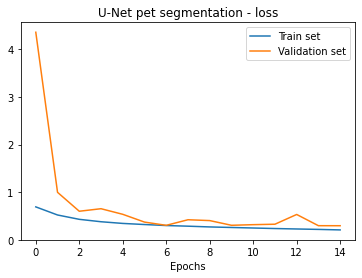

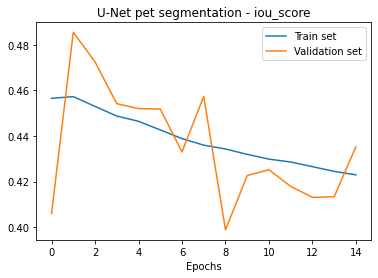

In [22]:
#let's use the function we just defined
plot_loss_history(history2, title = 'U-Net pet segmentation')

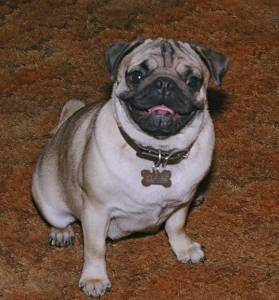

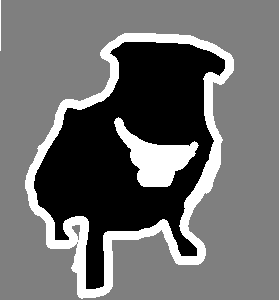

In [23]:
val_preds = model2.predict(val_gen)

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)